# EPA112 Programming for Data Science: Final Project
### Group 42: Angelica, Elena Deckert (6580300), Tadas Lukavicius(5525047)

# 1. Introduction

This cell installs all the necessary additional libraries.

In [1]:
!pip install pycountry -q
!pip install pycountry-convert -q
!pip install wbdata -q
!pip install ipywidgets -q

This cell imports all the necessary libraries

In [2]:
import logging
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import pycountry_convert
import json
from data_handler import Data_Handler
from completeness import Completeness_Ranker


# 2. Datasets

## 2.1 WBData completeness analysis

First, we completed a completeness analysis on the World Bank data. This was done because the data provided by the World Bank had a lot of factors; however, a lot of them had a lot of missing data. This was done by selecting the indicators that we were interested in, namely:
- Gender Disaggregated Labor Database (GDLD)
- Country Climate and Development Report (CCDR)
- Sustainable Development Goals
- Sustainable Energy for All
- Gender Statistics 

For each of these categories, we got all the data and checked how many NaN values there were per factor. This gave us valuable insight into which data can provide the most information for our further research.

In the next cell, we provide an example of such an analysis for the _Sustainable Energy for All_ indicator. We wanted to avoid clutter in this notebook, so the complete analysis can be found in the "WBData explore" notebook.

In [3]:
se_summary, se_df = Completeness_Ranker.rank_indicators_by_completeness(35, 2000, 2025, 10)
print(se_summary.head(15))

Found 11 indicators in source 35
Fetching data for all indicators...


Fetching indicators: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Retrieved 39126 data points


Calculating completeness: 100%|██████████| 11/11 [00:00<00:00, 346.46it/s]

                    Indicator Code  \
1    1.1_TOTAL.FINAL.ENERGY.CONSUM   
6               3.1_RE.CONSUMPTION   
8     4.1.2_REN.ELECTRICITY.OUTPUT   
9      4.1_SHARE.RE.IN.ELECTRICITY   
0       1.1_ACCESS.ELECTRICITY.TOT   
3     1.3_ACCESS.ELECTRICITY.URBAN   
7   4.1.1_TOTAL.ELECTRICITY.OUTPUT   
5       2.1_SHARE.TOTAL.RE.IN.TFEC   
2     1.2_ACCESS.ELECTRICITY.RURAL   
4               2.1_ACCESS.CFT.TOT   
10    6.1_PRIMARY.ENERGY.INTENSITY   

                                       Indicator Name  Completeness  \
1               Total final energy consumption (TFEC)      0.610782   
6                   Renewable energy consumption (TJ)      0.610782   
8           Renewable energy electricity output (GWh)      0.610618   
9   Renewable electricity (% in total electricity ...      0.610618   
0       Access to electricity (% of total population)      0.604043   
3       Access to electricity (% of urban population)      0.604043   
7                      Total electricity outpu

## 2.2 Pulling the data

Next, we chose data depending on their completeness and interest in our research.

From the World Bank data, we chose:
- Renewable energy share: Renewable electricity share of total electricity output (%): Electricity generated by power plants using renewable resources as a share of total electricity output.
- Basic drinking water:	The percentage of people using at least basic water services. This indicator encompasses both people using basic water services as well as those using safely managed water services.

From the Environmental Performance Index by Yale, we chose:
- Species protection index: measures how well a country's terrestrial protected areas overlap with the ranges of its vertebrate, invertebrate, and plant species.
- Air Polution SO2 trend: measures exposure to ground-level sulfur dioxide using a country’s ambient ground-level concentration.
- Ambient PM2.5 from human resources: measures the exposure to fine particulate matter pollution from anthropogenic sources, such as the burning of fossil fuels, which are easier to influence through policy than natural sources.
- Marine Habitat Protection: measures the percentage of the area of important marine and coastal habitats under official protection within a country’s Exclusive Economic Zone(s).

From the Human Development Index by United Nations, we chose:
- GII: composite metric of gender inequality using three dimensions: reproductive health, empowerment and the labour market. A low GII value indicates low inequality between women and men, and vice-versa.
- Shares of seats in the parliament, female: percentage of parliamentary seats held by women.
- Labour force participation, female: percentage of women who are working or actively seeking work.
- Population with secondary education, female: percentage of women who have completed secondary education.

In the next cell, we get the said data from according sources.

In [4]:
# Initialise data indicators and relative names for the columns in the data
indicators_wb = { "4.1_SHARE.RE.IN.ELECTRICITY" : "Renewable energy share",
                 "SH.H2O.BASW.ZS" :  "Basic drinking water"}
indicators_yale = { "SPI" : "Species protection index",
              "SDA" : "Air Polution SO2 trend",
              "HPE" : "Ambient PM2.5 from human resources", 
              "MHP" : "Marine Habitat Protection"}
indicators_hdi = {"gii" : "GII",
                 "pr_f" : "Shares of seats in the parliament",
                 "lfpr_f" : "Labour force participation",
                 "se_f" : "Population with secondary education"}

# Get world bank data
wbdata = Data_Handler.get_data_WB(
    indicators_wb, 
    countries="all", 
    start_year=1990, 
    end_year=2025
 )
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=1990,
    end_year=2025
)
# Get EPI data
epi_data = Data_Handler.get_data_EPI(
    indicators=indicators_yale,
    countries=None,
    start_year=1990,
    end_year=2025
)

In the next cell, we merge all data into one dataframe

In [5]:
# Rename columns for consistency
wbdata.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)

# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['country', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Pivot the EPI dataset 
epi_data_pivot = epi_data.pivot_table(
    index=['country', 'year'],
    columns='variable_name',     # Each variable_name becomes a column
    values='value'
).reset_index()

# Merge all three datasets on 'country' and 'year'
data = (
    wbdata
    .merge(hdi_data_pivot, on=['country', 'year'], how='outer')
    .merge(epi_data_pivot, on=['country', 'year'], how='outer')
)

## 2.3 Data preprocessing

In this section, we complete all necessary data preprocessing.

To get a standardised list of country names, we will be using pycountry. This library contains an ISO list of country names. Additionally, some "countries' are actually regions (e.g. Eurozone, the world, etc), so we skipped those as we are interested in the dynamics between different countries. We used a mapping of countries that were picked manually, because different datasets had different names for countries (e.g. "Czezh Republic" and "Czechia"), which was saved in a JSON format in the file country_names_mapping.json. This approach was done in order to reduce clutter in the notebook.

In [6]:
# Create a set of official country names from the pycountry library
pycountry_names = set([c.name for c in pycountry.countries])
country_map = {}
for name in data['country'].unique():
    if name in pycountry_names:
        country_map[name] = name

# Load a mapping file that contains manual corrections for country names not recognised by pycountry
with open("country_names_mapping.json", "r", encoding="utf-8") as f:
    map_update = json.load(f)

# Update the country_map with custom name mappings
country_map.update(map_update)
data['country'] = data['country'].map(country_map)

# Drop rows where 'country' is NaN
data = data.dropna(subset=['country'])

# Group by country and year to ensure unique records per pair
# If there are duplicates, `.first()` keeps the first occurrence
data = data.groupby(['country', 'year'], as_index=False).first()


In the next cell, we make a continent variable, which will later help us identify patterns between different continents.

In [7]:
def get_continent(country_name):
    try:
        # Try to find the country by exact name first
        country = pycountry.countries.get(name=country_name)
        
        # If not found, try fuzzy search
        if country is None:
            country = pycountry.countries.search_fuzzy(country_name)[0]
        
        # Get ISO Alpha-2 code
        country_code = country.alpha_2
        
        # Convert to continent code and name
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code)
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        
        return continent_name

    except Exception:
        return 'Unknown'

# Apply to your DataFrame
data['continent'] = data['country'].apply(get_continent)

After the previous cell, due to the mismatch between the names in the pycountry list and the dataset, a few countries were not identified. For these countries, we assigned the continent manually. This was done in the next two cells.

In [8]:
unknown_continent_countries = data[
    (data['continent'].isna()) | (data['continent'] == 'Unknown')
][['country']].drop_duplicates()

print(unknown_continent_countries)

                               country
1741  Democratic Republic Of The Congo
1916                        East Timor
4065                  Macao SAR, China
6280         Sint Maarten (Dutch part)
7519                    Western Sahara


In [9]:
data.loc[data["country"] == "Democratic Republic Of The Congo", "continent"] = "Africa"
data.loc[data["country"] == "Macao SAR, China", "continent"] = "Asia"
data.loc[data["country"] == "Sint Maarten (Dutch part)", "continent"] = "North America"
data.loc[data["country"] == "Western Sahara", "continent"] = "Africa"
data.loc[data["country"] == "East Timor", "continent"] = "Asia"

Later, we plotted the missing values by year in a bar graph.

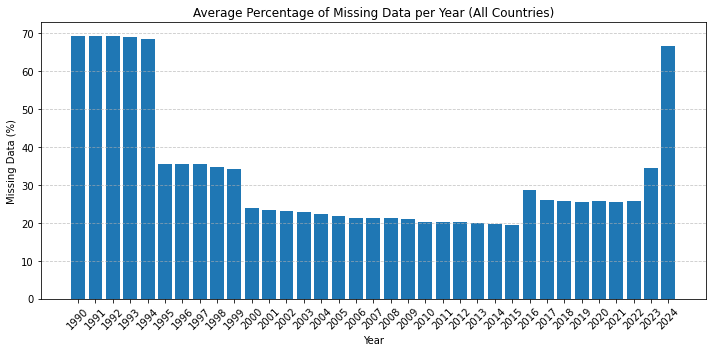

In [10]:
# Exclude trivial columns
cols_to_check = [c for c in data.columns if c not in ['year', 'country', 'continent']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see from the bar graph, a lot of the missing data is before 2000 and after 2022, thus, we have decided to exclude this data from our dataset.

In [11]:
data = data[(data['year'] >= 2000) & (data['year'] <= 2022)]

Next, we plot countries and the percentage of missing values per country.

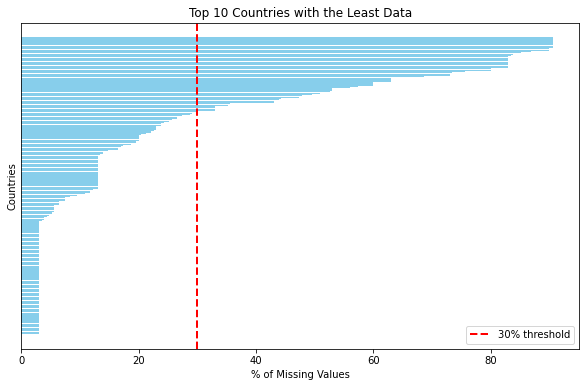

In [12]:
# Get NaN values by country
nan_by_country = data.groupby('country')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Top 10 Countries with the Least Data')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.

In [13]:
def nan_mean_excluding_marine(x):
    # Exclude 'Marine Habitat Protection' if all NaN for this country
    if 'Marine Habitat Protection' in x.columns and x['Marine Habitat Protection'].isna().all():
        return x.drop(columns=['Marine Habitat Protection']).isna().mean().mean() * 100
    else:
        return x.isna().mean().mean() * 100
before_excl = len(data["country"].unique())
# Compute missing-data percentage per country
country_nan_percent = data.groupby('country')[cols_to_check].apply(nan_mean_excluding_marine)

# Keep only countries with <= 30% missing data
valid_countries = country_nan_percent[country_nan_percent <= 30].index

# Filter the main DataFrame
data = data[data['country'].isin(valid_countries)]
after_excl = len(data["country"].unique())

print(f"{before_excl - after_excl} countries removed from the data.")

54 countries removed from the data.


Now, we want to inspect the trends of missing data between different factors in our dataset.

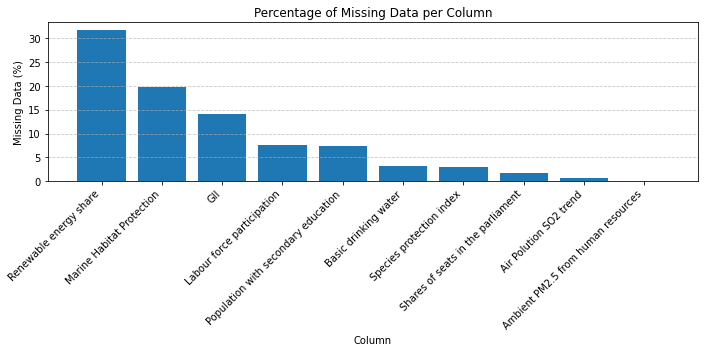


Missing data percentage per column (sorted):
Renewable energy share                 31.684457
Marine Habitat Protection              19.760479
GII                                    14.189013
Labour force participation              7.550117
Population with secondary education     7.367873
Basic drinking water                    3.150221
Species protection index                2.994012
Shares of seats in the parliament       1.822442
Air Polution SO2 trend                  0.598802
Ambient PM2.5 from human resources      0.000000
dtype: float64


In [14]:
# Get NaN values per column
nan_per_column = data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

From this bar graph, we can see that the renewable energy share factor has the most missing data. This is because it does not have any information after 2015. The second-highest factor in missing data is for Marine Habitat Protection. That is because there are landlocked countries, for example, Slovakia, which do not have access to seas or Oceans, and thus cannot have any marine habitat protection.

## 2.4 Uniformize data

Next, we look at the minimum and maximum values each column can obtain. All factors except for GII, are measured from 0 to 100. We have decided to multiply the GII by a factor of 100, as this will later help us visualize the results.

In [15]:
# Print min and max values of each column
min_max = data.agg(['min', 'max']).transpose().reset_index()
min_max.columns = ['Column', 'Min', 'Max']
print(min_max)

# Multiply GII by a 100
data['GII'] = data['GII'] * 100

                                 Column          Min            Max
0                               country  Afghanistan       Zimbabwe
1                                  year         2000           2022
2                Renewable energy share          0.0          100.0
3                  Basic drinking water    18.682303          100.0
4                                   GII        0.004           0.84
5            Labour force participation         5.72           94.4
6   Population with secondary education     1.761277          100.0
7     Shares of seats in the parliament          0.0       57.54717
8                Air Polution SO2 trend          0.0          100.0
9    Ambient PM2.5 from human resources          0.0          100.0
10            Marine Habitat Protection          0.0          100.0
11             Species protection index          0.0          100.0
12                            continent       Africa  South America


## 2.5 Basic Stats

Next we tried to get a general overview of the numeric value columns

In [16]:
data.describe()

year  Renewable energy share  Basic drinking water          GII  \
count  3841.000000             2624.000000           3720.000000  3296.000000   
mean   2011.000000               31.890783             85.693060    37.084466   
std       6.634113               33.464697             17.648528    19.622822   
min    2000.000000                0.000000             18.682303     0.400000   
25%    2005.000000                1.370591             78.045644    19.275000   
50%    2011.000000               17.543271             93.643147    38.100000   
75%    2017.000000               57.271726             99.154201    53.100000   
max    2022.000000              100.000000            100.000000    84.000000   

       Labour force participation  Population with secondary education  \
count                 3551.000000                          3558.000000   
mean                    50.238561                            55.301611   
std                     15.629789                            30.723977   
min                      5.720000                             1.761277   
25%                     42.055000                            26.974751   
50%                     51.860000                            56.493580   
75%                     59.280000                            85.360829   
max                     94.400000                           100.000000   

       Shares of seats in the parliament  Air Polution SO2 trend  \
count                        3771.000000             3818.000000   
mean                           19.042244               66.457622   
std                            11.409418               32.463057   
min                             0.000000                0.000000   
25%                            10.344828               41.725000   
50%                            17.600000               70.900000   
75%                            26.000000              100.000000   
max                            57.547170              100.000000   

       Ambient PM2.5 from human resources  Marine Habitat Protection  \
count                         3841.000000                3082.000000   
mean                            42.624004                  22.321836   
std                             29.878809                  22.625725   
min                              0.000000                   0.000000   
25%                             19.400000                   3.700000   
50%                             36.600000                  16.600000   
75%                             62.300000                  36.200000   
max                            100.000000                 100.000000   

       Species protection index  
count               3726.000000  
mean                  36.650188  
std                   27.507948  
min                    0.000000  
25%                   12.925000  
50%                   32.250000  
75%                   57.600000  
max                  100.000000

We analysed the amount of nan values and analysed if it makes sense to replace these or simply ignore the datapoints. Renewable energy share, GII, and Marine Habitat Protection have a high amount of missing values.
<5%	Simple mean/median	data[col].fillna(data[col].mean())
5–20%	Group mean/median	groupby(['continent','year'])
20–40%	Regression/KNN imputation	KNNImputer

In [17]:
data.isna().sum()

country                                   0
year                                      0
Renewable energy share                 1217
Basic drinking water                    121
GII                                     545
Labour force participation              290
Population with secondary education     283
Shares of seats in the parliament        70
Air Polution SO2 trend                   23
Ambient PM2.5 from human resources        0
Marine Habitat Protection               759
Species protection index                115
continent                                 0
dtype: int64

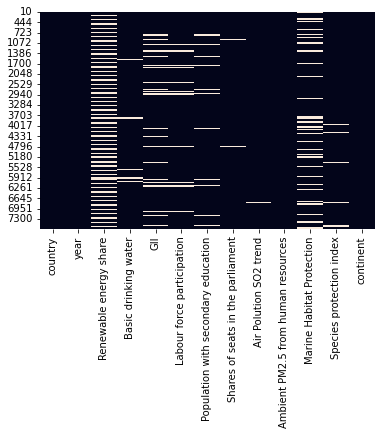

In [18]:
# visualize missing values
sns.heatmap(data.isna(), cbar=False)
plt.show()

# 3. Data Exploration
## 3.1 Distribution and Outliers
We start by getting a general idea for the values of our data set by plotting histograms and boxplots. With this we understand the distribution of values and can also see possible outliers.

array([[<AxesSubplot:title={'center':'Renewable energy share'}>,
        <AxesSubplot:title={'center':'Basic drinking water'}>,
        <AxesSubplot:title={'center':'GII'}>],
       [<AxesSubplot:title={'center':'Labour force participation'}>,
        <AxesSubplot:title={'center':'Population with secondary education'}>,
        <AxesSubplot:title={'center':'Shares of seats in the parliament'}>],
       [<AxesSubplot:title={'center':'Air Polution SO2 trend'}>,
        <AxesSubplot:title={'center':'Ambient PM2.5 from human resources'}>,
        <AxesSubplot:title={'center':'Marine Habitat Protection'}>],
       [<AxesSubplot:title={'center':'Species protection index'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

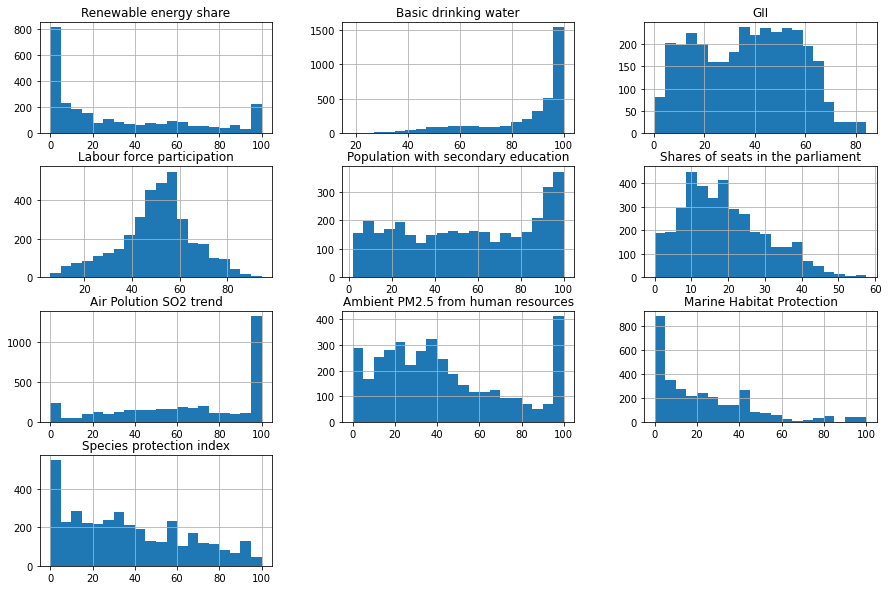

In [19]:
numeric_cols = [col for col in data.select_dtypes(include=np.number).columns if col not in ['year']]
data[numeric_cols].hist(figsize=(15,10), bins=20)

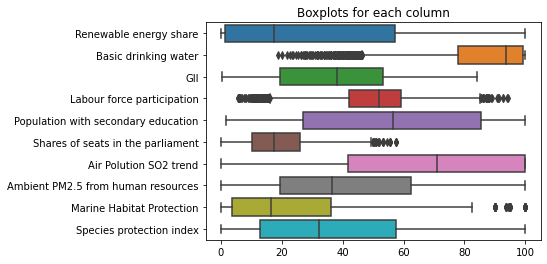

In [20]:
# boxplot to check for outliers
sns.boxplot(data=data[numeric_cols], orient="h")
plt.title("Boxplots for each column")
plt.show()

## 3.2 Continent & Country Analysis

Are some continents over or under represented

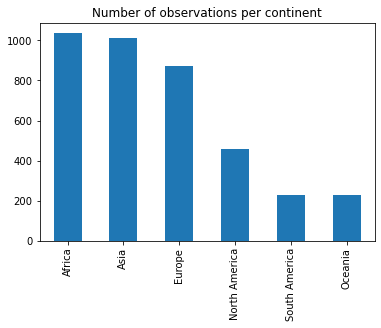

In [21]:
data['continent'].value_counts().plot(kind='bar', title='Number of observations per continent')
plt.show()

Is there generally a difference between continents and does it make sense to explore this.

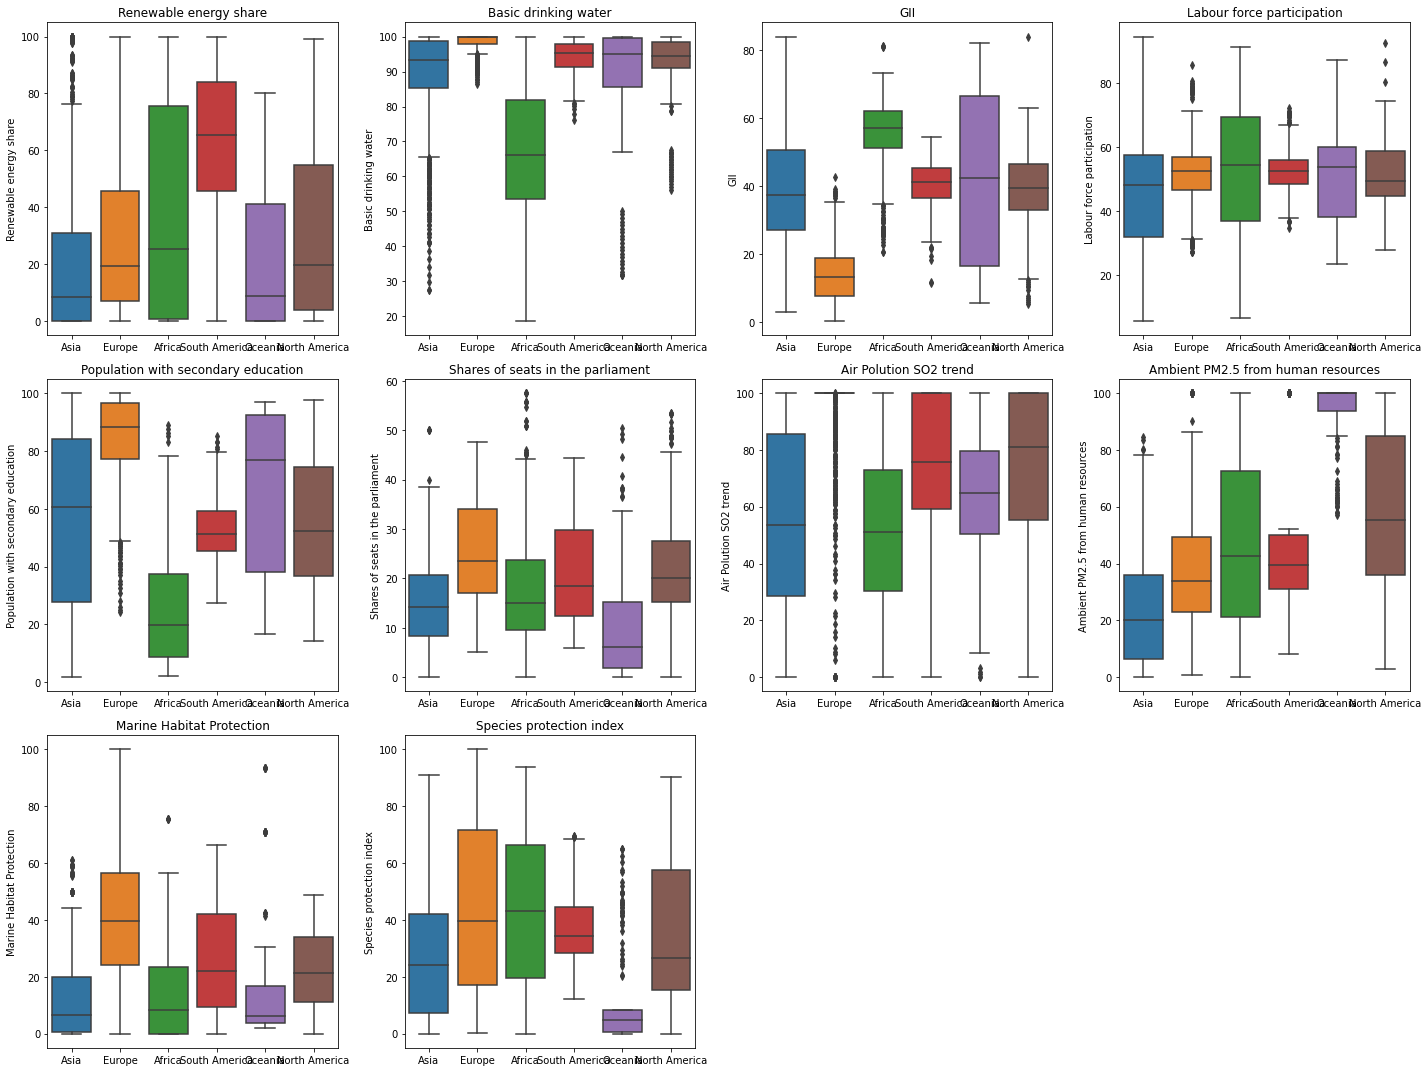

In [22]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=data, x='continent', y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

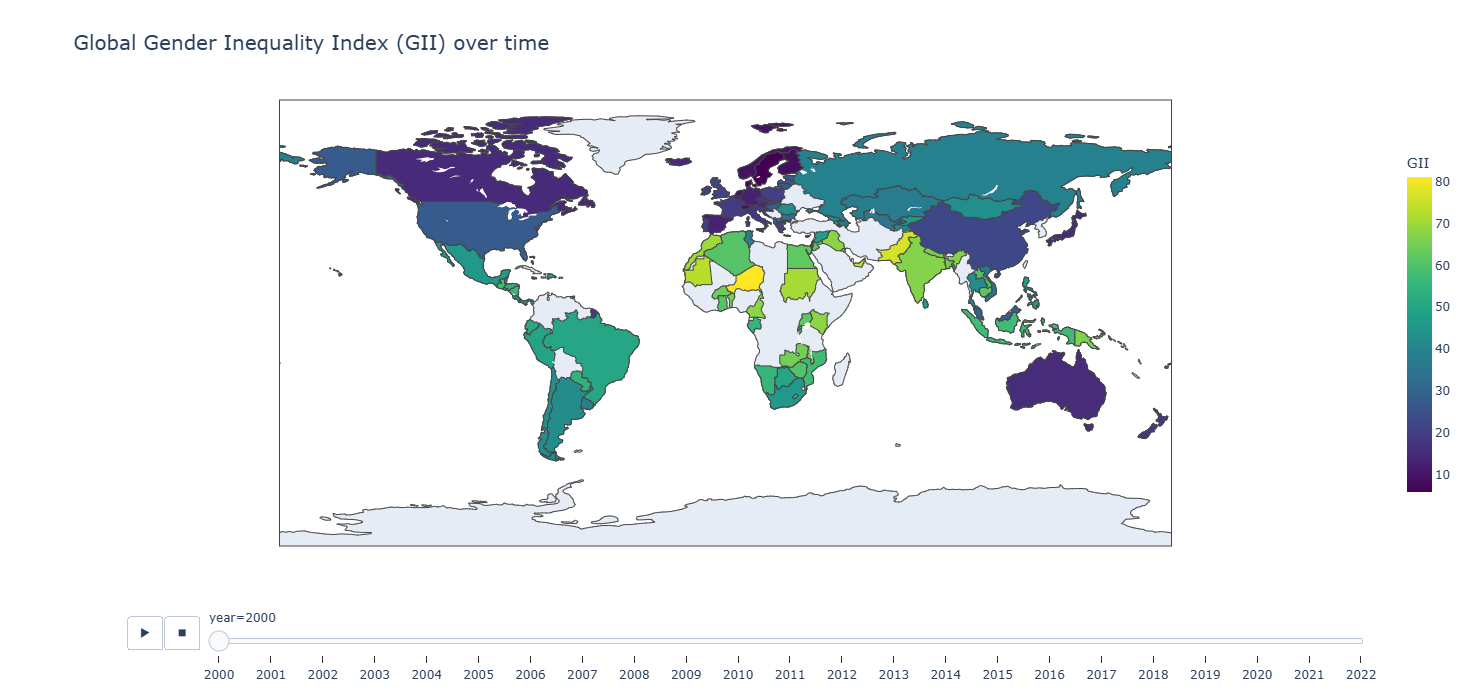

In [23]:
import plotly.express as px

fig = px.choropleth(
    data_frame=data,
    locations="country",
    locationmode="country names",
    color="GII",
    hover_name="country",
    animation_frame="year",
    color_continuous_scale="Viridis",
    title="Global Gender Inequality Index (GII) over time"
)

# set the layout of the figure
fig.update_layout(
    width=1200,      
    height=700,      
    coloraxis_colorbar=dict(
        title="GII",    
        thickness=25,  
        lenmode="fraction",
        len=0.8        
    ),
    title=dict(font=dict(size=20))  
)

fig.show()


## 3.3 Correlation

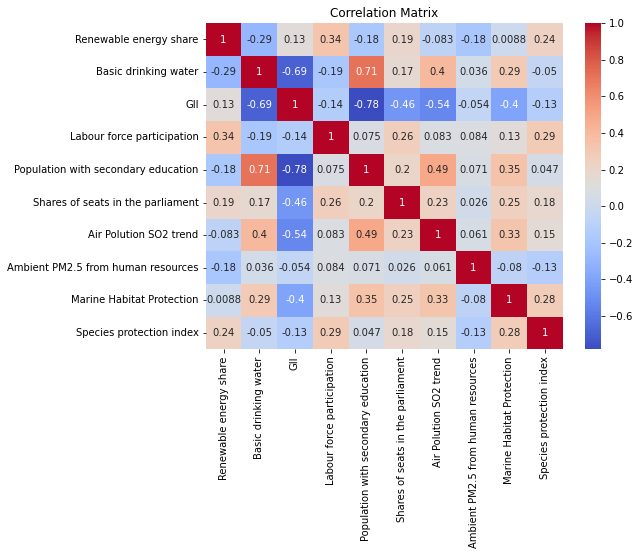

In [24]:
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

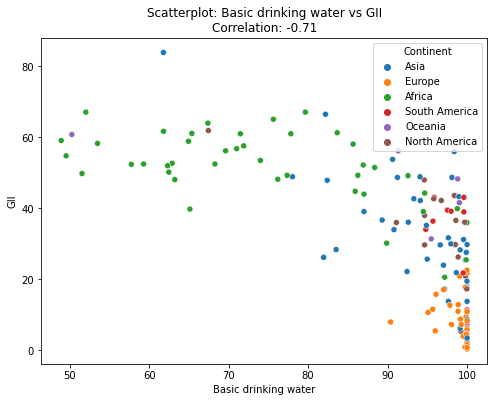

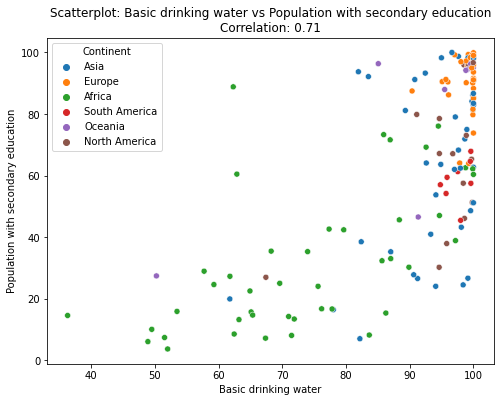

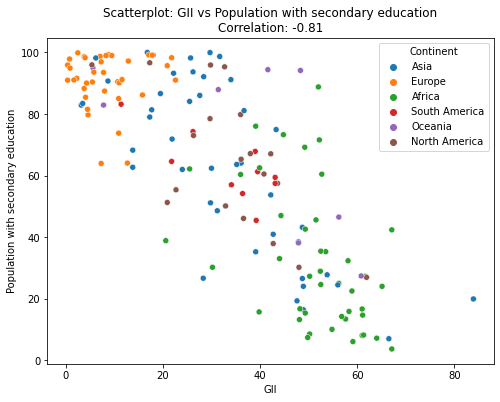

In [25]:
data_2022 = data[data["year"] == 2022]

# Compute correlation matrix
corr = data_2022[numeric_cols].corr()

# Find pairs with high correlation (> 0.7)
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and abs(corr.loc[col1, col2]) > 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

# Plot scatterplots for highly correlated pairs
for col1, col2 in high_corr:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=data_2022, x=col1, y=col2, hue='continent')
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend(title='Continent')
    plt.show()


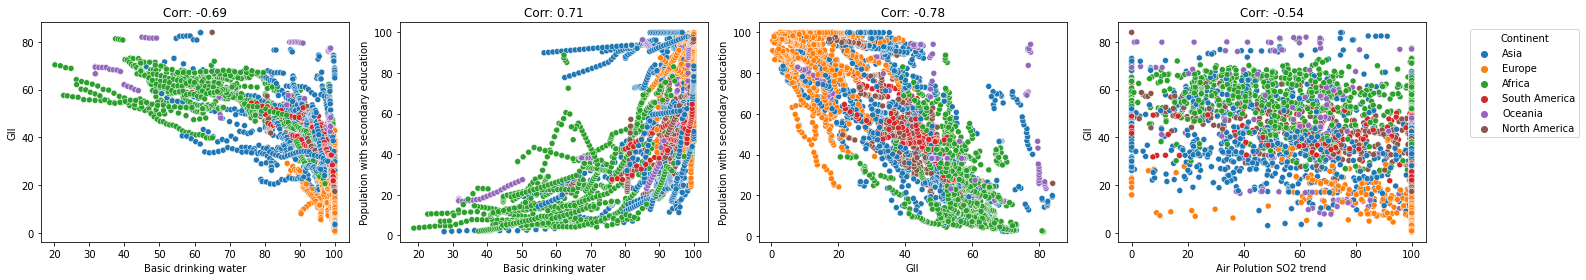

In [26]:
from math import ceil

corr = data[numeric_cols].corr()

# Relationships with 0.5 < correlation <= 0.7
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.5 < abs(corr.loc[col1, col2]) :
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

n_cols = 4
n_rows = ceil(len(high_corr)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each pair
for i, (x_col, y_col) in enumerate(high_corr):
    sns.scatterplot(data=data, x=x_col, y=y_col, hue='continent', ax=axes[i])
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)
    axes[i].set_title(f'Corr: {corr.loc[x_col, y_col]:.2f}')
    axes[i].legend_.remove()  

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.9), loc='upper left', title='Continent')

plt.tight_layout()
plt.show()

## 3.4 Temporal Trends

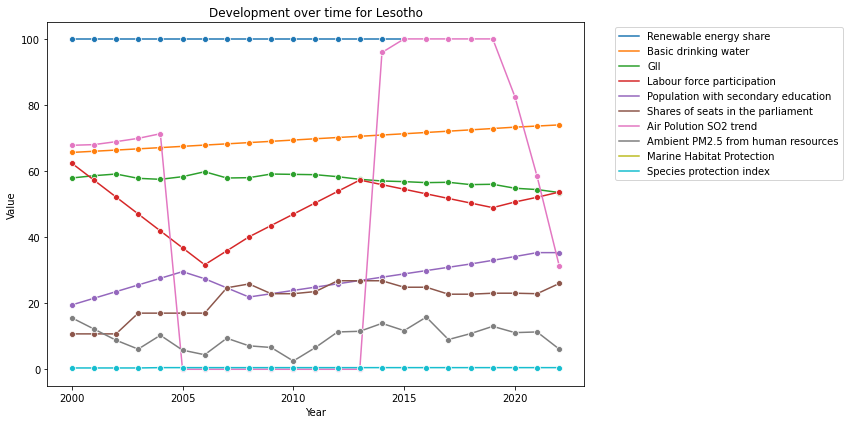

In [27]:
country_name = 'Lesotho'  

country_df = data[data['country'] == country_name]
 

plot_df = country_df.melt(id_vars='year', value_vars=numeric_cols, 
                          var_name='Indicator', value_name='Value')

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='year', y='Value', hue='Indicator', marker='o')
plt.title(f'Development over time for {country_name}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

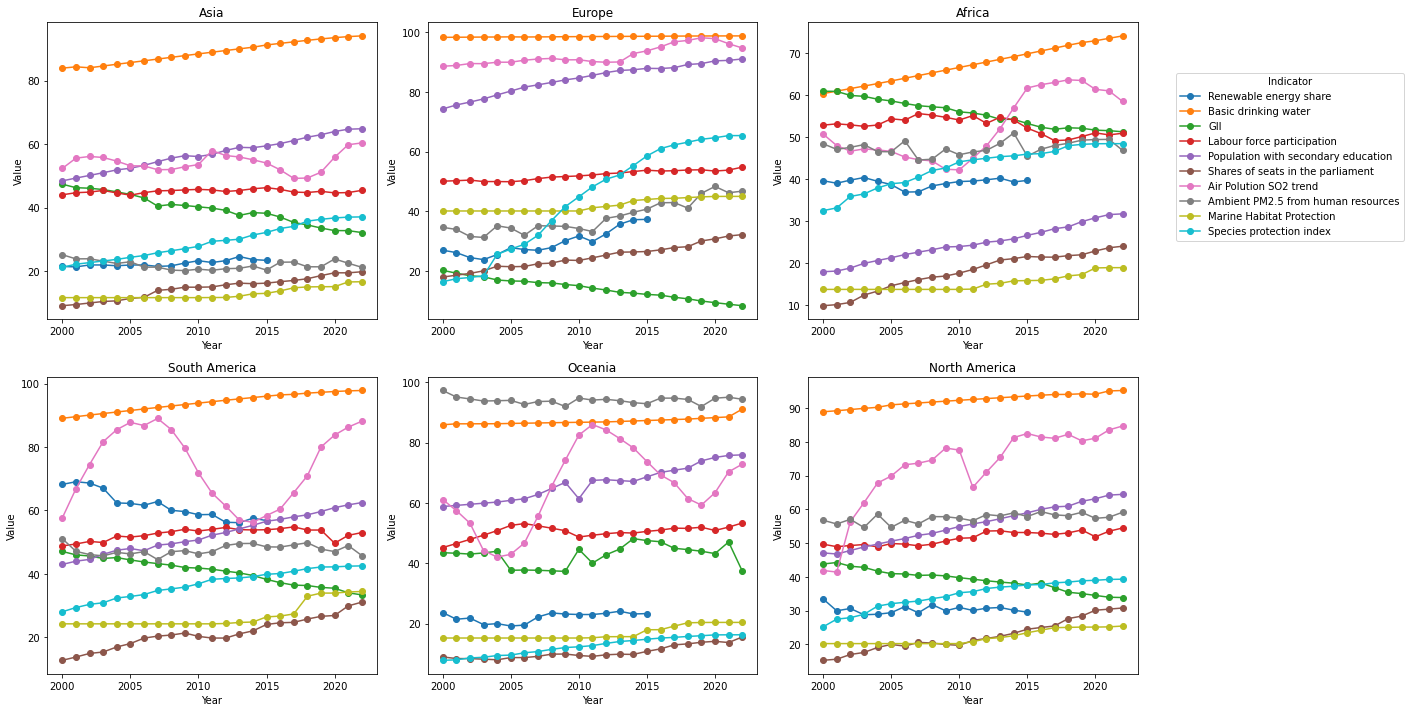

In [28]:
continents = data['continent'].unique()

# Grid layout
n_cols = 3
n_rows = int(np.ceil(len(continents)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatten()

for i, continent in enumerate(continents):
    continent_df = data[data['continent'] == continent]
    yearly_mean = continent_df.groupby('year')[numeric_cols].mean()
    
    # Plot each indicator
    for col in numeric_cols:
        axes[i].plot(yearly_mean.index, yearly_mean[col], marker='o', label=col)
    
    axes[i].set_title(continent)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')

# Single legend
fig.legend(numeric_cols, bbox_to_anchor=(1.02, 0.9), loc='upper left', title='Indicator')

plt.tight_layout()
plt.show()


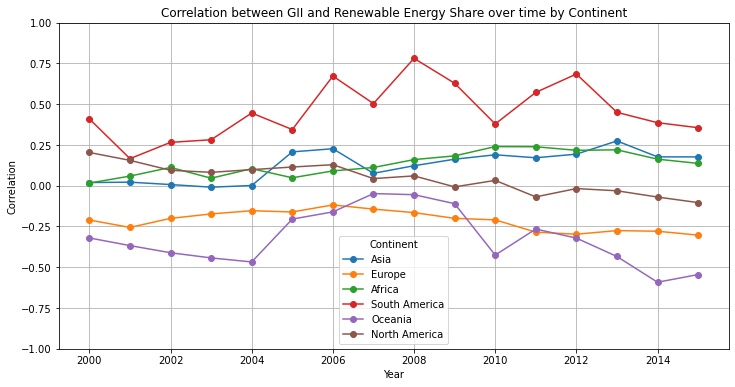

In [29]:
continents = data['continent'].unique()
years = sorted(data['year'].unique())

plt.figure(figsize=(12,6))

for continent in continents:
    correlations = []
    df_cont = data[data['continent'] == continent]
    
    for year in years:
        df_year = df_cont[df_cont['year'] == year][['GII', 'Renewable energy share']].dropna()
        if len(df_year) > 1:
            corr = df_year['GII'].corr(df_year['Renewable energy share'])
            correlations.append(corr)
        else:
            correlations.append(None)
    
    plt.plot(years, correlations, marker='o', label=continent)

plt.title('Correlation between GII and Renewable Energy Share over time by Continent')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(title='Continent')
plt.show()



# 4. Machine Learning

# Old Stuff

### Renewable energy share

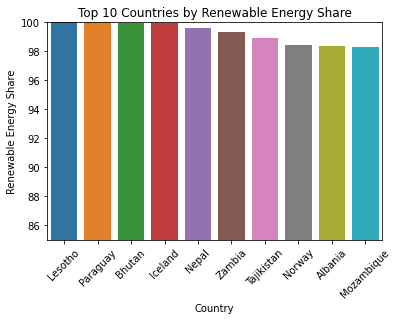

In [30]:
top_countries = data.groupby('country')['Renewable energy share'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Renewable Energy Share')
plt.ylabel('Renewable Energy Share')
plt.ylim(85, 100)
plt.xlabel('Country')
plt.show()

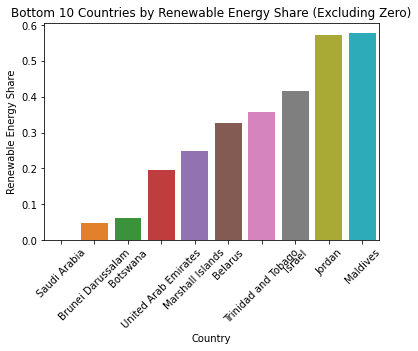

In [31]:
bottom_countries = (
    data[data['Renewable energy share'] > 0]
    .groupby('country')['Renewable energy share']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by Renewable Energy Share (Excluding Zero)')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Country')
plt.show()

In [32]:
sns.boxplot(data=merged, x='continent', y='Renewable_Energy_Share')
plt.title('Renewable Energy Share by Continent')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Continent')
plt.show()

NameError: name 'merged' is not defined

### GII

In [ ]:
top_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

In [ ]:
bottom_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=True).head(10)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

In [ ]:
sns.boxplot(data=merged, x='continent', y='GII')
plt.title('GII by Continent')
plt.ylabel('GII')
plt.xlabel('Continent')
plt.show()

### Let's see their relation

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='Renewable energy share', y='GII', legend=True)
plt.title('Relationship between Gender Inequality Index (GII) and Renewable Energy Share')
plt.xlabel('Renewable Energy Share')
plt.ylabel('Gender Inequality Index (GII)')
plt.show()

### Correlation exploration

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr = merged[merged["year"]==2022].corr(numeric_only=True)

# Relationships with correlation > 0.7
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and abs(corr.loc[col1, col2]) > 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

for col1, col2 in high_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

In [ ]:
corr = merged.corr(numeric_only=True)

# Relationships with 0.5 < correlation <= 0.7
medium_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.5 < abs(corr.loc[col1, col2]) <= 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in medium_corr:
                medium_corr.append(pair)

for col1, col2 in medium_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

## GII Correlation

In [ ]:
sns.pairplot(merged[['GII', 
                     'Labour force participation', 
                     'Shares of seats in the parliament', 
                     'population with secondary education', 
                     'continent']], 
             hue='continent')
plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display

variables = ['Labour force participation',
             'Shares of seats in the parliament',
             'population with secondary education']

agg_df = merged.groupby('country')[variables + ['GII']].mean().reset_index()

for var in variables:
    min_val = agg_df[var].min()
    max_val = agg_df[var].max()
    agg_df[var] = (agg_df[var] - min_val) / (max_val - min_val)


def update_plot(w1, w2, w3):
    total = w1 + w2 + w3
    if total == 0:
        return
    w1, w2, w3 = w1/total, w2/total, w3/total

    agg_df['weighted_indecators'] = (w1*agg_df[variables[0]] +
                                    w2*agg_df[variables[1]] +
                                    w3*agg_df[variables[2]])
    
    corr = agg_df['weighted_indecators'].corr(agg_df['GII'])
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=agg_df, x='weighted_indecators', y='GII', s=100)
    plt.title(f'Weighted Indicators vs GII\nCorrelation: {corr:.2f}')
    plt.xlabel('Weighted Indicator')
    plt.ylabel('GII')
    plt.show()

w1_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Labour')
w2_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Parliament')
w3_slider = widgets.FloatSlider(value=0.34, min=0, max=1, step=0.05, description='Education')

sliders = widgets.VBox([w1_slider, w2_slider, w3_slider])
figure = widgets.interactive_output(update_plot, {'w1': w1_slider, 'w2': w2_slider, 'w3': w3_slider})

display(sliders, figure)
